<a href="https://colab.research.google.com/github/AnkurMali/IST597_Spring_2022/blob/main/IST597_MLP_collab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IST597:- Multi-Layer Perceptron

## Load the libraries

In [ ]:
import os
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score
import keras
import time
import math
import tensorflow as tf
import torch.nn as nn
from keras.datasets import fashion_mnist
from numpy import sqrt

seed=97238684
np.random.seed(seed)
tf.random.set_seed(seed)
# np.random.seed(1234)
# tf.random.set_seed(1234)
from sklearn.model_selection import train_test_split


In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Define the input, output and hidden layer sizes


In [ ]:
size_input = 784
size_hidden1 = 512
size_hidden2 = 256
size_hidden3 = 128
size_output = 10
starter_learning_rate = 0.001
regularizer_rate = 0.1


#Load the MNIST dataset and define train, test and validation sets

In [ ]:
train_ratio = 0.80
validation_ratio = 0.10
test_ratio = 0.10

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X = np.concatenate([X_train, X_test])
y = np.concatenate([y_train, y_test])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=(1-train_ratio))
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=((test_ratio/(validation_ratio+test_ratio))))

X_train.shape

(56000, 28, 28)

#Load the FMNIST dataset and define train, test and validation sets

In [ ]:

(Xtrain_fmnist, ytrain_fmnist), (Xtest_fmnist, ytest_fmnist) = fashion_mnist.load_data()
X_fmnist = np.concatenate([Xtrain_fmnist, Xtest_fmnist])
y_fmnist = np.concatenate([ytrain_fmnist, ytest_fmnist])

Xtrain_fmnist, X_val_fmnist, ytrain_fmnist, y_val_fmnist = train_test_split(X_fmnist, y_fmnist, test_size=(1-train_ratio))
X_val_fmnist, Xtest_fmnist, y_val_fmnist, ytest_fmnist = train_test_split(X_val_fmnist, y_val_fmnist, test_size=((test_ratio/(validation_ratio+test_ratio))))

#Reshape the train, test and validation sets (MNIST)

In [ ]:

# (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = np.reshape(X_train, (56000, 784))
X_test = np.reshape(X_test, (-1, 784))
X_train = X_train.astype(float) / 255
X_test = X_test.astype(float) / 255
X_val = np.reshape(X_val, (7000,784))
X_val=X_val/255.0
X_val=tf.cast(X_val,dtype=tf.float32)
y_train = tf.one_hot(y_train,10)
y_test = tf.one_hot(y_test,10)

#Reshape the train, test and validation sets (FMNIST)

In [ ]:
Xtrain_fmnist = np.reshape(X_train, (56000, 784))
Xtest_fmnist = np.reshape(X_test, (-1, 784))
Xtrain_fmnist = Xtrain_fmnist.astype(float) / 255
Xtest_fmnist = Xtest_fmnist.astype(float) / 255
X_val_fmnist = np.reshape(X_val_fmnist, (7000,784))
X_val_fmnist=X_val_fmnist.astype(float) /255.0
ytrain_fmnist = tf.one_hot(ytrain_fmnist,10)
ytest_fmnist = tf.one_hot(ytest_fmnist,10)

In [ ]:
print(X_train.shape, y_train.shape)
print(Xtrain_fmnist.shape, ytrain_fmnist.shape)

(56000, 784) (56000, 10)
(56000, 784) (56000, 10)


In [ ]:
print("y_train: ",y_train)
print("y_val: ",y_val)
print("y_test: ",y_test)

y_train:  tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]], shape=(56000, 10), dtype=float32)
y_val:  [4 2 6 ... 6 2 5]
y_test:  tf.Tensor(
[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]], shape=(7000, 10), dtype=float32)


In [ ]:
# Split MNIST dataset into batches
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(16)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(2)

In [ ]:
# Split FMNIST dataset into batches
train_ds_fmnist = tf.data.Dataset.from_tensor_slices((Xtrain_fmnist, ytrain_fmnist)).batch(16)
test_ds_fmnist = tf.data.Dataset.from_tensor_slices((Xtest_fmnist, ytest_fmnist)).batch(4)
val_ds_fmnist = tf.data.Dataset.from_tensor_slices((X_val_fmnist, y_val_fmnist)).batch(2)

## Build MLP using Eager Execution without Regularization

In [ ]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden1, self.size_hidden2, self.size_hidden3, self.size_output, self.device =\
    size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device 
    
    # Initialize weights between input layer and hidden layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1]))
    # Initialize weights between hidden layers
    self.W_h1 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2]))
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden1]))
     # Initialize weights between hidden layers
    self.W_h2 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_hidden3]))
    # Initialize weights between hidden layer and output layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden3, self.size_output]))
    # Initialize biases for output layer
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden2]))
    self.b3 = tf.Variable(tf.random.normal([1, self.size_hidden3]))
    self.b4 = tf.Variable(tf.random.normal([1, self.size_output]))
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W_h1, self.W_h2, self.W2, self.b1, self.b2, self.b3, self.b4]


        
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y


  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    # loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred,labels=y_true)) \
    #     + regularizer_rate*(tf.reduce_sum(tf.square(self.b1)) + tf.reduce_sum(tf.square(self.b2)) + \
    #                         tf.reduce_sum(tf.square(self.b3)) + tf.reduce_sum(tf.square(self.b4)) + \
    #                         tf.nn.l2_loss(self.W1) + tf.nn.l2_loss(self.W_h1) + tf.nn.l2_loss(self.W_h2) + tf.nn.l2_loss(self.W2) )
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred,labels=y_true))
    
    # return loss
    


  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    # optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    # optimizer = tf.keras.optimizers.Adam(
    # learning_rate=0.001, epsilon=1e-07, amsgrad=False,
    # name='Adam')
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))


  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    
    # Compute values in hidden layer
    what_i = tf.matmul(X_tf, self.W1) + self.b1
    hhat_i = tf.nn.relu(what_i)
    what_h1 = tf.matmul(hhat_i, self.W_h1) + self.b2
    hhat_h1 = tf.nn.relu(what_h1)
    what_h2 = tf.matmul(hhat_h1, self.W_h2) + self.b3
    hhat_h2 = tf.nn.relu(what_h2)
    what_out = tf.matmul(hhat_h2, self.W2) + self.b4
    hhat = tf.nn.relu(what_out)
    # Compute output
    output_i = tf.matmul(hhat_i, self.W_h1) + self.b2
    output_h1 = tf.matmul(hhat_h1, self.W_h2) + self.b3
    output = tf.matmul(hhat_h2, self.W2) + self.b4
    return output

 # Calculate standard error
  def stderr(self,y_pred):
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    std_dev = np.std(y_pred_tf) #Calculates standard deviation
    std_err = std_dev/sqrt(len(y_pred_tf))
    return std_err 

 # Calculate variance error
  def var(self,y_pred):
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    std_dev = np.std(y_pred_tf) #Calculates standard deviation
    variance = (std_dev**2) # calculate variance
    return variance 

  def cat_accuracy(self, y_pred,y_true):
    return tf.cast(tf.equal(tf.argmax(y_true, axis=-1),tf.argmax(y_pred, axis=-1)),tf.keras.backend.floatx())


## Train Model

In [ ]:
# Set number of epochs
NUM_EPOCHS = 10

In [ ]:
# Initialize model using GPU MNIST Data on train data

mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='gpu')
print("model using CPU MNIST Data Without Regularization on Train data")
time_start = time.time()
acc_mnist_train=[]
acc_mnist_test=[]
for epoch in range(NUM_EPOCHS):
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  accuracy_train=0
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(seed)).batch(100)
  for inputs, outputs in train_ds:
    preds = mlp_on_cpu.forward(inputs)
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    lt = lt + mlp_on_cpu.loss(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs)
    accuracy_train=tf.keras.metrics.CategoricalAccuracy()
    accuracy_train.update_state(preds, outputs)
  acc_mnist_train.append(np.sum(loss_total) / X_train.shape[0])
  print('Number of Epoch = {} - Average Cross Entropy:= {}, Accuracy:= {}'.format(epoch + 1, np.sum(loss_total) / X_train.shape[0], accuracy_train.result()*100))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs


model using CPU MNIST Data Without Regularization on Train data
Number of Epoch = 1 - Average Cross Entropy:= 13.457877232142858, Accuracy:= 80.0
Number of Epoch = 2 - Average Cross Entropy:= 4.502041294642857, Accuracy:= 89.0
Number of Epoch = 3 - Average Cross Entropy:= 3.181255859375, Accuracy:= 85.0
Number of Epoch = 4 - Average Cross Entropy:= 2.491190011160714, Accuracy:= 87.0
Number of Epoch = 5 - Average Cross Entropy:= 2.042404994419643, Accuracy:= 90.0
Number of Epoch = 6 - Average Cross Entropy:= 1.7421519252232143, Accuracy:= 89.0
Number of Epoch = 7 - Average Cross Entropy:= 1.5103563058035714, Accuracy:= 90.0
Number of Epoch = 8 - Average Cross Entropy:= 1.3378405412946428, Accuracy:= 88.0
Number of Epoch = 9 - Average Cross Entropy:= 1.1999453125, Accuracy:= 90.0
Number of Epoch = 10 - Average Cross Entropy:= 1.08328515625, Accuracy:= 92.0

Total time taken (in seconds): 177.46


In [ ]:
# Initialize model using GPU MNIST Data on Test data

mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='gpu')
print("model using GPU MNIST Data Without Regularization on Test data")
time_start = time.time()
acc_mnist_test=[]
for epoch in range(NUM_EPOCHS):
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  accuracy_test=0
  train_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).shuffle(25, seed=epoch*(seed)).batch(100)
  for inputs, outputs in test_ds:
    preds = mlp_on_cpu.forward(inputs)
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    lt = lt + mlp_on_cpu.loss(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs)
    accuracy_test=tf.keras.metrics.CategoricalAccuracy()
    accuracy_test.update_state(preds, outputs)
  acc_mnist_test.append(np.sum(loss_total) / X_test.shape[0])
  print('Number of Epoch = {} - Average Cross Entropy:= {}, Accuracy:= {}'.format(epoch + 1, np.sum(loss_total) / X_test.shape[0], accuracy_test.result()*100))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs

model using GPU MNIST Data Without Regularization on Test data
Number of Epoch = 1 - Average Cross Entropy:= 205.31421428571429, Accuracy:= 100.0
Number of Epoch = 2 - Average Cross Entropy:= 29.93509375, Accuracy:= 100.0
Number of Epoch = 3 - Average Cross Entropy:= 13.579109375, Accuracy:= 100.0
Number of Epoch = 4 - Average Cross Entropy:= 7.510904575892857, Accuracy:= 100.0
Number of Epoch = 5 - Average Cross Entropy:= 4.934040736607143, Accuracy:= 100.0
Number of Epoch = 6 - Average Cross Entropy:= 3.5423387276785716, Accuracy:= 100.0
Number of Epoch = 7 - Average Cross Entropy:= 2.5098758370535714, Accuracy:= 100.0
Number of Epoch = 8 - Average Cross Entropy:= 2.0056180245535713, Accuracy:= 100.0
Number of Epoch = 9 - Average Cross Entropy:= 1.60450390625, Accuracy:= 100.0
Number of Epoch = 10 - Average Cross Entropy:= 1.1582278878348213, Accuracy:= 100.0

Total time taken (in seconds): 527.96


In [ ]:
# Initialize model using GPU Fashion MNIST Data on train data

mlp_on_gpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='gpu')
print("model using GPU Fashion MNIST Data Without Regularization on Train data")
time_start = time.time()
acc_fmnist_train=[]
for epoch in range(NUM_EPOCHS):
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  accu_train_fmnist=0
  train_ds_fmnist = tf.data.Dataset.from_tensor_slices((Xtrain_fmnist, ytrain_fmnist)).shuffle(25, seed=epoch*(seed)).batch(100)
  for inputs, outputs in train_ds_fmnist:
    preds = mlp_on_gpu.forward(inputs)
    loss_total = loss_total + mlp_on_gpu.loss(preds, outputs)
    lt = lt + mlp_on_cpu.loss(preds, outputs)
    mlp_on_gpu.backward(inputs, outputs)
    accu_train_fmnist=tf.keras.metrics.CategoricalAccuracy()
    accu_train_fmnist.update_state(preds, outputs)
  acc_fmnist_train.append(np.sum(loss_total) / X_train.shape[0])
  print('Number of Epoch = {} - Average Cross Entropy:= {}, Accuracy:= {}'.format(epoch + 1, np.sum(loss_total) / Xtrain_fmnist.shape[0], accu_train_fmnist.result()*100))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs

model using GPU Fashion MNIST Data Without Regularization on Train data
Number of Epoch = 1 - Average Cross Entropy:= 1.7145040457589287, Accuracy:= 13.0
Number of Epoch = 2 - Average Cross Entropy:= 1.2123295200892856, Accuracy:= 7.0
Number of Epoch = 3 - Average Cross Entropy:= 1.0037972237723214, Accuracy:= 5.0
Number of Epoch = 4 - Average Cross Entropy:= 0.8362370954241072, Accuracy:= 9.0
Number of Epoch = 5 - Average Cross Entropy:= 0.7329169224330357, Accuracy:= 9.0
Number of Epoch = 6 - Average Cross Entropy:= 0.6850256696428572, Accuracy:= 7.0
Number of Epoch = 7 - Average Cross Entropy:= 0.6340092075892857, Accuracy:= 8.0
Number of Epoch = 8 - Average Cross Entropy:= 0.5678643275669643, Accuracy:= 10.0
Number of Epoch = 9 - Average Cross Entropy:= 0.5247691824776786, Accuracy:= 14.0
Number of Epoch = 10 - Average Cross Entropy:= 0.49849672154017854, Accuracy:= 6.0

Total time taken (in seconds): 173.07


In [ ]:
# # Initialize model using GPU Fashion MNIST Data on test data

# mlp_on_gpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='gpu')
# print("model using GPU Fashion MNIST Data Without Regularization on Test data")
# time_start = time.time()
# acc_fmnist_test=[]
# for epoch in range(NUM_EPOCHS):
#   loss_total = tf.zeros([1,1], dtype=tf.float32)
#   lt = 0
#   accu_test_fmnist=0
#   test_ds_fmnist = tf.data.Dataset.from_tensor_slices((Xtest_fmnist, ytest_fmnist)).shuffle(25, seed=epoch*(seed)).batch(100)
#   for inputs, outputs in test_ds_fmnist:
#     preds = mlp_on_gpu.forward(inputs)
#     loss_total = loss_total + mlp_on_gpu.loss(preds, outputs)
#     lt = lt + mlp_on_cpu.loss(preds, outputs)
#     mlp_on_gpu.backward(inputs, outputs)
#     accu_test_fmnist=tf.keras.metrics.CategoricalAccuracy()
#     accu_test_fmnist.update_state(preds, outputs)
#   acc_fmnist_test.append(np.sum(loss_total) / Xtest_fmnist.shape[0])
#   print('Number of Epoch = {} - Average Cross Entropy:= {}, Accuracy:= {}'.format(epoch + 1, np.sum(loss_total) / Xtest_fmnist.shape[0], accu_test_fmnist.result()*100))
# time_taken = time.time() - time_start

# print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
# #For per epoch_time = Total_Time / Number_of_epochs

In [ ]:
# Initialize model using GPU Fashion MNIST Data on train data

mlp_on_tpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='tpu')
print("model using TPU Fashion MNIST Data Without Regularization on Test data")
time_start = time.time()

acc_fmnist_test=[]
for epoch in range(NUM_EPOCHS):
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  accu_test_fmnist=0
  test_ds_fmnist = tf.data.Dataset.from_tensor_slices((Xtest_fmnist, ytest_fmnist)).shuffle(25, seed=epoch*(seed)).batch(100)
  for inputs, outputs in test_ds_fmnist:
    preds = mlp_on_cpu.forward(inputs)
    loss_total = loss_total + mlp_on_tpu.loss(preds, outputs)
    lt = lt + mlp_on_tpu.loss(preds, outputs)
    mlp_on_tpu.backward(inputs, outputs)
    accu_test_fmnist=tf.keras.metrics.CategoricalAccuracy()
    accu_test_fmnist.update_state(preds, outputs)
  acc_fmnist_test.append(np.sum(loss_total) / Xtest_fmnist.shape[0])
  print('Number of Epoch = {} - Average Cross Entropy:= {}, Accuracy:= {}'.format(epoch + 1, np.sum(loss_total) / Xtest_fmnist.shape[0], accu_test_fmnist.result()*100))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs


model using TPU Fashion MNIST Data Without Regularization on Test data
Number of Epoch = 1 - Average Cross Entropy:= 5.800516183035715, Accuracy:= 11.0
Number of Epoch = 2 - Average Cross Entropy:= 5.8005150669642855, Accuracy:= 12.0
Number of Epoch = 3 - Average Cross Entropy:= 5.800513950892857, Accuracy:= 11.0
Number of Epoch = 4 - Average Cross Entropy:= 5.800513392857143, Accuracy:= 9.0
Number of Epoch = 5 - Average Cross Entropy:= 5.8005150669642855, Accuracy:= 11.0
Number of Epoch = 6 - Average Cross Entropy:= 5.800515625, Accuracy:= 12.0
Number of Epoch = 7 - Average Cross Entropy:= 5.800514508928571, Accuracy:= 11.0
Number of Epoch = 8 - Average Cross Entropy:= 5.800514508928571, Accuracy:= 9.0
Number of Epoch = 9 - Average Cross Entropy:= 5.800515625, Accuracy:= 10.0
Number of Epoch = 10 - Average Cross Entropy:= 5.800515625, Accuracy:= 9.0

Total time taken (in seconds): 28.42


## One Step Inference

In [ ]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
acc_preds = tf.Variable(0,dtype=tf.float32)
for inputs, outputs in test_ds:
  preds = mlp_on_cpu.forward(inputs)
  # print(preds)
  b = mlp_on_cpu.loss(preds, outputs)
  standard_error = mlp_on_cpu.stderr(preds) 
  test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, outputs)
  Variance = mlp_on_cpu.var(preds) 

  for i in range(preds.shape[0]):
    if tf.argmax(preds[i])==tf.argmax(outputs[i]):
      acc_preds = acc_preds + 1.0
acc = (acc_preds/X_test.shape[0])*100.0
print('Inference for Test Data Regular')
print('Test MSE: {:.4f}'.format(np.sum(test_loss_total.numpy())/X_train.shape[0]))
print('Accuracy: {:.4f}'.format(acc))
print('Standard Error: {:.4f}'.format(standard_error))
print('Variance: {:.4f}'.format(Variance))

print('Test MSE: {:.4f}'.format(np.sum(test_loss_total.numpy()) / X_train.shape[0]))

Inference 1st
Test MSE: 0.3104
Accuracy: 81.2000
Standard Error: 394.6757
Variance: 623075.6002
Test MSE: 0.3104


In [ ]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
acc_preds = tf.Variable(0,dtype=tf.float32)
#test_loss_total = 0.0
for inputs, outputs in test_ds_fmnist:
  preds = mlp_on_cpu.forward(inputs)
  # print(preds)
  b = mlp_on_cpu.loss(preds, outputs)
  standard_error = mlp_on_cpu.stderr(preds) # Standard error
  # print(b)
  test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, outputs)
# a = (test_loss_total.numpy() / X_train.shape[0])
# print(X_train.shape[0])
  Variance = mlp_on_cpu.var(preds) # Variance

  for i in range(preds.shape[0]):
    if tf.argmax(preds[i])==tf.argmax(outputs[i]):
      acc_preds = acc_preds + 1.0
acc = (acc_preds/Xtest_fmnist.shape[0])*100.0
print('Inference Fashion MNIST Test data Regular')
print('Test MSE: {:.4f}'.format(np.sum(test_loss_total.numpy())/Xtest_fmnist.shape[0]))
print('Accuracy: {:.4f}'.format(acc))
print('Standard Error: {:.4f}'.format(standard_error))
print('Variance: {:.4f}'.format(Variance))

print('Test MSE: {:.4f}'.format(np.sum(test_loss_total.numpy()) / Xtest_fmnist.shape[0]))

Inference 1st
Test MSE: 3.0099
Accuracy: 10.0857
Standard Error: 4.5629
Variance: 83.2797
Test MSE: 3.0099


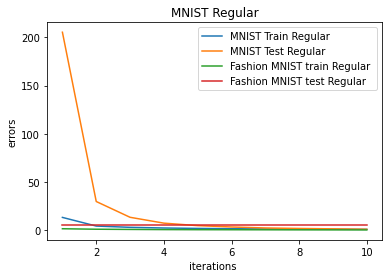

In [ ]:
# Plot learning curve (with errors)
import matplotlib.pyplot as plt
%matplotlib inline
iterations = [1,2,3,4,5,6,7,8,9,10]
errors_train = np.squeeze(acc_mnist_train)
errors_test = np.squeeze(acc_mnist_test)
errors_train1 = np.squeeze(acc_fmnist_train)
errors_test1 = np.squeeze(acc_fmnist_test)
plt.plot(iterations,errors_train,label='MNIST Train Regular')
plt.plot(iterations,errors_test,label='MNIST Test Regular ')
plt.plot(iterations,errors_train1,label='Fashion MNIST train Regular ')
plt.plot(iterations,errors_test1,label='Fashion MNIST test Regular')
plt.ylabel('errors')
plt.xlabel('iterations ')
plt.title("MNIST Regular")
plt.legend()
plt.show()